## Gutenberg Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
from tqdm import tqdm
import csv
import json
import numpy as np
import pickle
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
folder = '/content/drive/MyDrive/cse475/GUTENBERG'

In [ ]:
directories = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

num_directories = len(directories)

print(f"Number of authors: {num_directories}")

Number of authors: 12886


In [ ]:
directories[0]

'J._Daley_McDonald'

In [ ]:
authors_dirs = {}

In [ ]:
for i in tqdm(range(0, len(directories))):
    directory = directories[i]
    path = os.path.join(folder, directory)
    files = os.listdir(path)
    if len(files) > 20:
      authors_dirs[directory] = len(files)

100%|██████████| 12886/12886 [00:13<00:00, 948.89it/s]


In [ ]:
with open("/content/drive/MyDrive/cse475/authors_dirs.json", "w") as f:
  json.dump(authors_dirs, f)

In [ ]:
sorted_authors = sorted(authors_dirs.items(), key=lambda item: item[1], reverse=True)
len(sorted_authors)

211

In [ ]:
sorted_authors = [author for author in sorted_authors if author[0] != 'Anonymous']
len(sorted_authors)

210

In [ ]:
sorted_authors = [author for author in sorted_authors if author[1] >= 20]
len(sorted_authors)

210

In [ ]:
sorted_authors[1][1]

175

In [7]:
csv_file_path = '/content/drive/MyDrive/cse475/files_and_authors.csv'

In [ ]:
def strip_gutenberg_content_start(text):
  start_marker = "*** START OF THE PROJECT GUTENBERG"
  end_marker = "***"
  splits = text.split(start_marker)
  if len(splits) >= 2:
    content = splits[1].split(end_marker)[1]
    return content
  else:
    return text

def strip_gutenberg_content_end(text):
  start_marker = "*** END OF THE PROJECT GUTENBERG"
  splits = text.split(start_marker)
  if len(splits) >= 2:
    content = splits[0]
    return content
  else:
    return text

In [ ]:
with open(csv_file_path, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['Author', 'Content'])

  pbar = tqdm(range(len(sorted_authors)), desc='All authors')
  # pbar = tqdm(range(1), desc='All authors')
  for i in pbar:
    author = sorted_authors[i][0]
    path = os.path.join(folder, author)
    files = os.listdir(path)

    for j in range(20):
      file = files[j]
      file_path = os.path.join(path, file)
      with open(file_path, 'r') as f:
        content = f.read().strip().replace('\n', '')
        content = strip_gutenberg_content_start(content)
        content = strip_gutenberg_content_end(content)
        writer.writerow([author, '"' + content + '"'])

All authors: 100%|██████████| 210/210 [01:47<00:00,  1.95it/s]


## Using our dataset

In [8]:
df = pd.read_csv(csv_file_path)
df

,Author,Content
0,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by Sue Asscher and David WidgerRIENZ..."
1,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by John T. Horner and David WidgerTH..."
2,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by Fred Ihde and David WidgerTHE COM..."
3,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by Dianne Bean, and David CeponisTHE..."
4,Baron_Edward_Bulwer_Lytton_Lytton,"""Produced by Dave Ceponis, Sue Asscher and Dav..."
...,...,...
4195,Annie_Besant,"""Produced by David Widger. *THE CHRISTI..."
4196,Annie_Besant,"""Produced by Jana Srna, Bryan Ness, Margo Romb..."
4197,Annie_Besant,"""Produced by David Widger from page images gen..."
4198,Annie_Besant,"""Produced by Larry B. Harrison, Bryan Ness and..."


In [5]:
df.describe()

,Author,Content
count,4200,4200
unique,210,4198
top,Baron_Edward_Bulwer_Lytton_Lytton,""""""
freq,20,3


In [6]:
df["Author"].unique()

array(['Baron_Edward_Bulwer_Lytton_Lytton', 'Georg_Ebers',
       'Alexandre_Dumas', 'Honoré_de_Balzac', 'Gilbert_Parker',
       'George_Manville_Fenn', 'Charles_Dickens', 'George_Meredith',
       'G._A._Henty', 'Arthur_Conan_Doyle', 'Émile_Zola', 'Andrew_Lang',
       'Jack_London', 'H._G._Wells', 'George_Sand', 'Henry_James',
       'graf_Leo_Tolstoy', 'Johann_Wolfgang_von_Goethe',
       'Anthony_Trollope', 'Edward_Stratemeyer', 'Guy_de_Maupassant',
       'Edward_Sylvester_Ellis', 'H._Rider_Haggard', 'Eugène_Sue',
       'George_MacDonald', 'Fergus_Hume', 'Charlotte_M._Yonge',
       'Bret_Harte', 'Carolyn_Wells', 'Anatole_France', 'Dante_Alighieri',
       'James_Grant', 'E._Phillips_Oppenheim', 'Daniel_Defoe',
       'John_Galsworthy', 'G._K._Chesterton', 'Henrik_Ibsen',
       'Friedrich_Schiller', 'Jacob_Abbott', 'George_O._Smith',
       'Benito_Pérez_Galdós', 'Charles_James_Lever',
       'August_Strindberg', 'Edgar_Rice_Burroughs', 'Bernard_Shaw',
       'Arnold_Benne

## Term frequency vectorizer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA

In [9]:
# stylometry works best between 400-1000 features as per my research on my capstone project
# here I used 750 max features to minimize training time but keeping a good enough accuracy
ds_tfidf_vect = TfidfVectorizer(min_df=0.5, stop_words="english", max_features=750)
ds_freqs = ds_tfidf_vect.fit_transform(df['Content'])

In [10]:
len(ds_tfidf_vect.vocabulary_)

750

In [11]:
ds_freqs = ds_freqs.todense()

In [12]:
ds_freqs_df = pd.DataFrame(ds_freqs, index=df['Author'])
ds_freqs_df = ds_freqs_df.reset_index()
ds_freqs_df

,Author,0,1,2,3,4,5,6,7,8,...,740,741,742,743,744,745,746,747,748,749
0,Baron_Edward_Bulwer_Lytton_Lytton,0.011995,0.014361,0.006929,0.012386,0.020202,0.024198,0.003541,0.000000,0.040765,...,0.007594,0.005185,0.008493,0.010774,0.001531,0.015106,0.043142,0.048183,0.094152,0.054173
1,Baron_Edward_Bulwer_Lytton_Lytton,0.003887,0.017634,0.006467,0.004014,0.003367,0.012904,0.002479,0.000000,0.030117,...,0.004027,0.006913,0.006605,0.007855,0.002680,0.013024,0.030634,0.059330,0.089795,0.051075
2,Baron_Edward_Bulwer_Lytton_Lytton,0.005404,0.098066,0.014048,0.005580,0.017552,0.005606,0.005743,0.000000,0.099169,...,0.002799,0.006007,0.014348,0.010921,0.006209,0.026629,0.073518,0.021706,0.121229,0.018053
3,Baron_Edward_Bulwer_Lytton_Lytton,0.000000,0.010828,0.000000,0.034501,0.005168,0.004952,0.015219,0.000000,0.004866,...,0.034613,0.010612,0.000000,0.024115,0.005485,0.000000,0.062698,0.105452,0.109359,0.026577
4,Baron_Edward_Bulwer_Lytton_Lytton,0.003175,0.013503,0.013204,0.018849,0.006015,0.019762,0.004218,0.000000,0.046122,...,0.007400,0.012351,0.010115,0.008822,0.004560,0.005475,0.033509,0.072527,0.086372,0.063634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,Annie_Besant,0.007996,0.009070,0.004157,0.012385,0.012986,0.008296,0.021247,0.000000,0.052991,...,0.012426,0.000000,0.029723,0.004040,0.004594,0.003940,0.123792,0.004015,0.030534,0.013357
4196,Annie_Besant,0.063703,0.024915,0.002284,0.018146,0.057078,0.004558,0.000000,0.000000,0.013437,...,0.000000,0.000000,0.016330,0.002220,0.005048,0.002165,0.016488,0.002206,0.006291,0.004892
4197,Annie_Besant,0.008145,0.012317,0.005646,0.039247,0.061727,0.000000,0.000000,0.003103,0.013840,...,0.005625,0.000000,0.002883,0.016460,0.003120,0.010703,0.030567,0.002726,0.002592,0.009070
4198,Annie_Besant,0.012942,0.011009,0.000000,0.016704,0.056047,0.000000,0.010316,0.000000,0.026389,...,0.000000,0.000000,0.065286,0.127500,0.007436,0.003189,0.000000,0.009747,0.012354,0.007206


In [15]:
ds_freqs_df.to_csv('ds_freqs_df.csv')

## Principal Component Analysis

In [17]:
pca = PCA(n_components=3)
vects_reduced = pca.fit_transform(np.asarray(ds_freqs))
vects_reduced.shape

(4200, 3)

In [18]:
pca_df = pd.DataFrame(
    vects_reduced,
    columns=['1st comp', '2nd comp', '3rd comp'],
    index=df["Author"]
)
pca_df

,1st comp,2nd comp,3rd comp
Author,,,
Baron_Edward_Bulwer_Lytton_Lytton,-0.183214,0.176764,-0.041742
Baron_Edward_Bulwer_Lytton_Lytton,-0.203016,0.089466,-0.040146
Baron_Edward_Bulwer_Lytton_Lytton,-0.105515,0.284060,-0.076429
Baron_Edward_Bulwer_Lytton_Lytton,0.029325,0.095895,-0.128292
Baron_Edward_Bulwer_Lytton_Lytton,-0.178195,0.207524,-0.031320
...,...,...,...
Annie_Besant,0.125680,0.319703,-0.056759
Annie_Besant,0.172387,0.381147,-0.056002
Annie_Besant,0.230417,0.178208,-0.017532


<ipython-input-19-3d6b2731501f>:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_coord, y_coord, marker='o', c=author_colors[title], edgecolors='k')


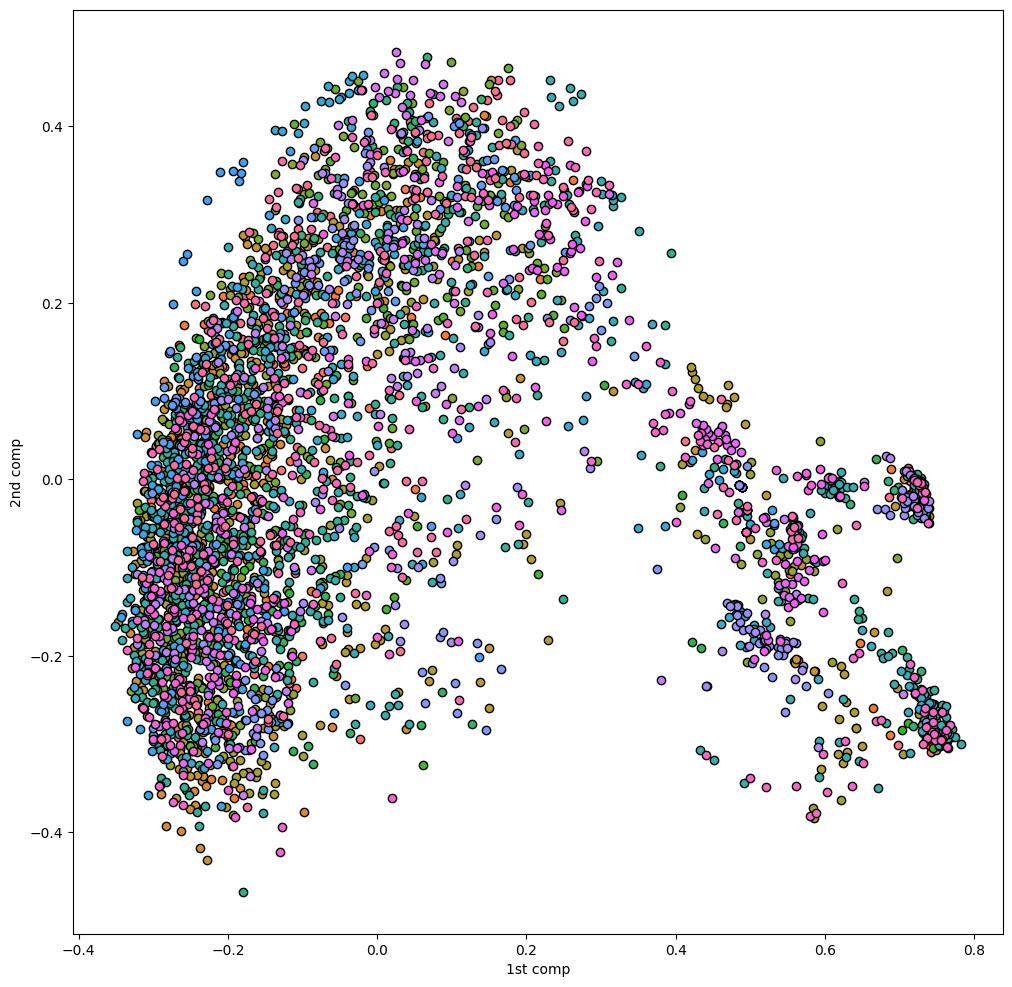

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("husl", len(df['Author'].unique()))
author_colors = dict(zip(df['Author'].unique(), colors))

ax = pca_df.plot(kind="scatter", x='1st comp', y='2nd comp', figsize=(12,12))

for title, points in pca_df.iterrows():
  x_coord = points['1st comp']
  y_coord = points['2nd comp']
  ax.scatter(x_coord, y_coord, marker='o', c=author_colors[title], edgecolors='k')

plt.show()


<ipython-input-20-d69561446a63>:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_coord, y_coord, z_coord, marker='o', c=author_colors[title], edgecolors='k')


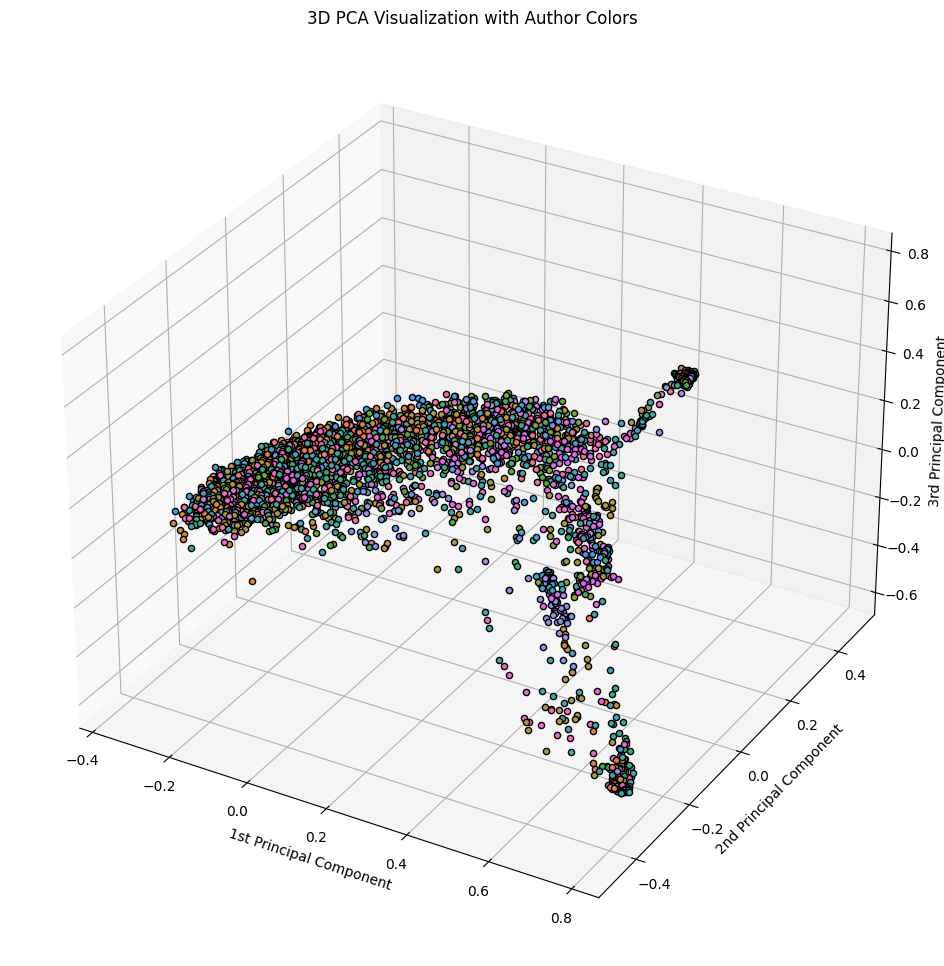

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

colors = sns.color_palette("husl", len(df['Author'].unique()))
author_colors = dict(zip(df['Author'].unique(), colors))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for title, points in pca_df.iterrows():
  x_coord = points['1st comp']
  y_coord = points['2nd comp']
  z_coord = points['3rd comp']
  ax.scatter(x_coord, y_coord, z_coord, marker='o', c=author_colors[title], edgecolors='k')

ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
ax.set_zlabel("3rd Principal Component")
ax.set_title("3D PCA Visualization with Author Colors")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(ds_freqs_df.drop('Author', axis=1), ds_freqs_df['Author'], test_size=0.2, random_state=2024)

## Classification Models

### Logistic regression

In [23]:
param_grid = {
  'penalty': ['l1', 'l2'],
  'C': [0.001, 0.01, 0.1, 1, 10],
  'solver': ['lbfgs', 'sag']
}

log_models_grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)

log_models_grid.fit(X_train, y_train)
print(f"Best Parameters: {log_models_grid.best_params_}")

best_log_model = log_models_grid.best_estimator_
y_pred = best_log_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy: 0.7988


In [24]:
log_best_model_path = "/content/drive/MyDrive/cse475/log_best_model.pkl"
with open(log_best_model_path, 'wb') as f:
  pickle.dump(best_log_model, f)

### Random Forest

In [ ]:
param_grid = {
  'n_estimators': [10, 50, 100, 200],
  'max_depth': [4, 8, 12],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'max_features': ['sqrt', 'log2']
}

rand_models_grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)

rand_models_grid.fit(X_train, y_train)
print(f"Best Parameters: {rand_models_grid.best_params_}")

best_rand_model = rand_models_grid.best_estimator_
y_pred = best_rand_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Parameters: {'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Test Accuracy: 0.6083


In [ ]:
rand_best_model_path = "/content/drive/MyDrive/cse475/rand_best_model.pkl"
with open(rand_best_model_path, 'wb') as f:
  pickle.dump(best_rand_model, f)

### Support Vector Machine

In [ ]:
param_grid = {
  'C': [0.01, 0.1, 1, 10, 100],
  'kernel': ['linear', 'rbf'],
  'gamma': ['auto', 0.01, 0.1, 1],
  'probability': [True]
}

svm_grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)

svm_grid.fit(X_train, y_train)
print(f"Best Parameters: {svm_grid.best_params_}")

best_svm_model = svm_grid.best_estimator_
y_pred = best_svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}
Test Accuracy: 0.8167


In [ ]:
svm_best_model_path = "/content/drive/MyDrive/cse475/svm_best_model.pkl"
with open(svm_best_model_path, 'wb') as f:
  pickle.dump(best_svm_model, f)

## Ensemble voting

### Ensemble Voting (hard)

In [ ]:
ensemble_model_hard = VotingClassifier(estimators=[
    ('lr', best_log_model), ('svm', best_svm_model), ('rf', best_rand_model)], voting='hard')

ensemble_model_hard.fit(X_train, y_train)

y_pred = ensemble_model_hard.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Ensembled Accuracy (hard): {accuracy:.4f}")

Ensembled Accuracy (hard): 0.7869


### Ensemble Voting (soft)

In [ ]:
ensemble_model_soft = VotingClassifier(estimators=[
    ('lr', best_log_model), ('svm', best_svm_model), ('rf', best_rand_model)], voting='soft')

ensemble_model_soft.fit(X_train, y_train)

y_pred = ensemble_model_soft.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Ensembled Accuracy (soft): {accuracy:.4f}")

Ensembled Accuracy (soft): 0.7988


## Training an LSTM

In [14]:
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support

In [15]:
le = LabelEncoder()
y_encoded = le.fit_transform(ds_freqs_df['Author'])
# original_labels = le.inverse_transform(y_encoded)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(ds_freqs_df.drop('Author', axis=1), y_encoded, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [17]:
del df

In [18]:
X_train_LSTM = X_train.to_numpy()
X_test_LSTM = X_test.to_numpy()

In [26]:
lstm_model = keras.Sequential([
    layers.Embedding(input_dim=X_train_LSTM.shape[1], output_dim=64),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_model.fit(X_train_LSTM, y_train, epochs=10, batch_size=42, validation_data=(X_val.to_numpy(), y_val))

Epoch 1/10
60/60 [==============================] - 234s 4s/step - loss: 5.3484 - accuracy: 0.0032 - val_loss: 5.3532 - val_accuracy: 0.0024
Epoch 2/10
60/60 [==============================] - 224s 4s/step - loss: 5.3469 - accuracy: 0.0048 - val_loss: 5.3512 - val_accuracy: 0.0024
Epoch 3/10
60/60 [==============================] - 203s 3s/step - loss: 5.3459 - accuracy: 0.0036 - val_loss: 5.3556 - val_accuracy: 0.0000e+00
Epoch 4/10
60/60 [==============================] - 239s 4s/step - loss: 5.3441 - accuracy: 0.0063 - val_loss: 5.3565 - val_accuracy: 0.0000e+00
Epoch 5/10
60/60 [==============================] - 204s 3s/step - loss: 5.3430 - accuracy: 0.0056 - val_loss: 5.3644 - val_accuracy: 0.0000e+00
Epoch 6/10
60/60 [==============================] - 203s 3s/step - loss: 5.3407 - accuracy: 0.0063 - val_loss: 5.3750 - val_accuracy: 0.0000e+00
Epoch 7/10
60/60 [==============================] - 202s 3s/step - loss: 5.3393 - accuracy: 0.0048 - val_loss: 5.3801 - val_accuracy: 0.00

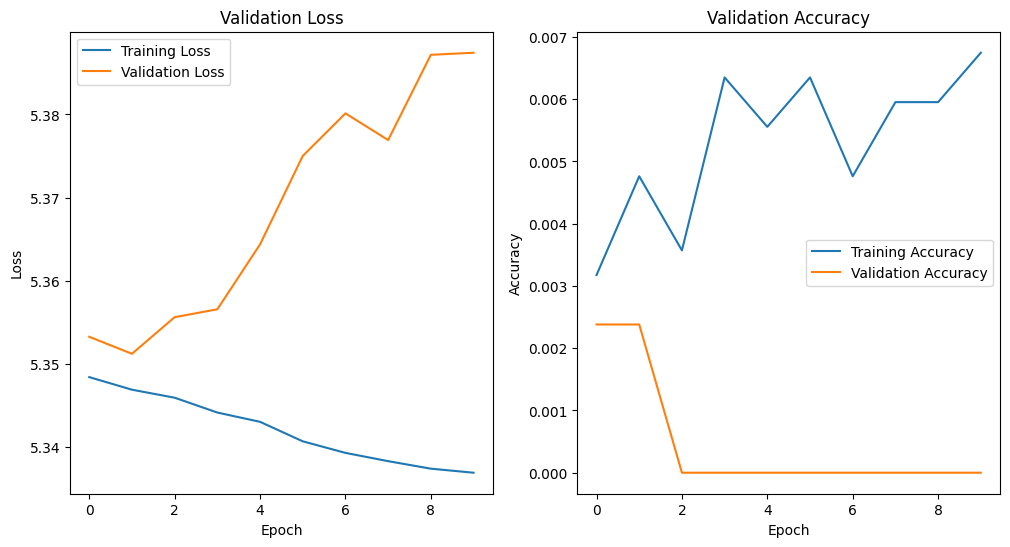

In [31]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.set_title('Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


### Conclusion: model be fit

: how fit are you ?

: yes ✅

***Too fit to unfit***

In [33]:
y_pred = lstm_model.predict(X_test_LSTM)
y_pred = np.argmax(y_pred, axis=1)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


27/27 [==============================] - 30s 993ms/step
Precision: 0.0036
Recall: 0.0036
F1 Score: 0.0036
